<a href="https://colab.research.google.com/github/Sprattler/TD3_OpenLoop_PIDTuner/blob/main/TD3_Agent_PID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --force-reinstall torch --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6

In [ ]:
!pip install wandb

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from collections import deque
import wandb

# --------------------------------------------------------------
# Konfiguration
# --------------------------------------------------------------
# Pendel
TARGET_ANGLE = math.radians(70)
GRAVITY = 9.81
LENGTH = 0.1
MASS = 0.3
DAMPING = 0.05
MAX_TORQUE = 20
MIN_TORQUE = -MAX_TORQUE
I = MASS * (LENGTH ** 2)

# 1s Simulation mit logging
MAX_STEPS = 1500
DT = 0.001

# TD3
EPISODES = 650
ACTOR_LR = 5e-3
CRITIC_LR = 5e-3
DISCOUNT = 0.97
TAU = 0.005

POLICY_NOISE = 0.2
NOISE_CLIP = 0.5
POLICY_FREQ = 2

EXPLORATION_NOISE = 0
BATCH_SIZE = 256
REPLAY_BUFFER_SIZE = 1e6

# Initiale PID-Parameter
KP_INIT = 50
KI_INIT = 1.0
KD_INIT = 1.0

# --------------------------------------------------------------
# PendelEnv mit PID
# --------------------------------------------------------------
class PendulumEnv(gym.Env):
    def __init__(self):
        super(PendulumEnv, self).__init__()
        self.dt = DT
        self.target = TARGET_ANGLE
        self.max_steps = MAX_STEPS
        self.g = GRAVITY
        self.L = LENGTH
        self.I = MASS * (LENGTH ** 2)
        self.damping = DAMPING

        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=MIN_TORQUE, high=MAX_TORQUE, shape=(1,), dtype=np.float32)

        # PID-Parameter
        self.Kp = KP_INIT
        self.Ki = KI_INIT
        self.Kd = KD_INIT

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.theta = 0.0
        self.theta_dot = 0.0
        self.integral = 0.0
        self.prev_error = self.target - self.theta
        error = self.prev_error
        derivative = 0.0
        return np.array([error, self.integral, derivative], dtype=np.float32), {}

    def step(self, action=None):
        # Wenn keine Aktion gegeben, nutze PID-Regler
        if action is None:
            error = self.target - self.theta
            u = self.Kp * error + self.Ki * self.integral + self.Kd * ((error - self.prev_error) / self.dt)
            u = np.clip(u, MIN_TORQUE, MAX_TORQUE)
        else:
            u = action[0]

        # Physikalische Simulation
        theta_dot_new = self.theta_dot + self.dt * (
            - (self.damping / self.I) * self.theta_dot
            - (self.g / self.L) * np.sin(self.theta)
            + (1.0 / self.I) * u
        )
        theta_new = self.theta + self.dt * theta_dot_new

        self.theta = theta_new
        self.theta_dot = theta_dot_new
        self.current_step += 1

        # Zustandsaktualisierung
        error = self.target - self.theta
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error

        observation = np.array([error, self.integral, derivative], dtype=np.float32)

        terminated = self.current_step >= self.max_steps
        truncated = False
        info = {'theta': self.theta, 'u': u}
        return observation, terminated, truncated, info

    def set_pid_params(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd

# --------------------------------------------------------------
# Actor (mit PID-Layer)
# --------------------------------------------------------------
class FullyConnectedPILayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FullyConnectedPILayer, self).__init__()
        # Initialisiere Gewichte positiv
        self.weights = nn.Parameter(torch.abs(torch.randn(output_size, input_size)))

    def forward(self, x):
        return torch.nn.functional.linear(x, self.weights, bias=None)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.pi_layer = FullyConnectedPILayer(input_size=state_dim, output_size=action_dim)

    def forward(self, state):
        return self.pi_layer(state)

# --------------------------------------------------------------
# (Twin) - Critic
# --------------------------------------------------------------
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.q1 = nn.Linear(64, 1)

        self.fc1_2 = nn.Linear(state_dim + action_dim, 64)
        self.fc2_2 = nn.Linear(64, 64)
        self.q2 = nn.Linear(64, 1)

    def forward(self, state, action):
        xu = torch.cat([state, action], 1)
        x1 = torch.relu(self.fc1(xu))
        x1 = torch.relu(self.fc2(x1))
        q1 = self.q1(x1)

        x2 = torch.relu(self.fc1_2(xu))
        x2 = torch.relu(self.fc2_2(x2))
        q2 = self.q2(x2)
        return q1, q2

    def Q1(self, state, action):
        xu = torch.cat([state, action], 1)
        x1 = torch.relu(self.fc1(xu))
        x1 = torch.relu(self.fc2(x1))
        return self.q1(x1)

# --------------------------------------------------------------
# Replay Buffer
# --------------------------------------------------------------
class ReplayBuffer(object):
    def __init__(self, max_size=REPLAY_BUFFER_SIZE):
        self.storage = deque(maxlen=int(max_size))

    def add(self, data):
        self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        batch = [self.storage[i] for i in ind]
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(np.array(states)),
            torch.FloatTensor(np.array(actions)),
            torch.FloatTensor(np.array(rewards)).unsqueeze(1),
            torch.FloatTensor(np.array(next_states)),
            torch.FloatTensor(np.array(dones)).unsqueeze(1)
        )

# --------------------------------------------------------------
# TD3 Agent
# --------------------------------------------------------------
class TD3:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim)
        self.actor_target = Actor(state_dim, action_dim)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=ACTOR_LR)

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=CRITIC_LR)

        self.max_action = max_action
        self.total_it = 0

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1))
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=BATCH_SIZE, discount=DISCOUNT, tau=TAU, policy_noise=POLICY_NOISE, noise_clip=NOISE_CLIP, policy_freq=POLICY_FREQ):
        self.total_it += 1
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            noise = (torch.randn_like(action) * policy_noise).clamp(-noise_clip, noise_clip)
            next_action = self.actor_target(next_state) + noise
            next_action = next_action.clamp(MIN_TORQUE, self.max_action)
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1 - done) * discount * target_Q).detach()

        current_Q1, current_Q2 = self.critic(state, action)
        critic_loss = nn.MSELoss()(current_Q1, target_Q) + nn.MSELoss()(current_Q2, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.total_it % policy_freq == 0:
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Gewichte clippen auf min 0
            self.actor.pi_layer.weights.data.clamp_(min=0)
            self.actor_target.pi_layer.weights.data.clamp_(min=0)

            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

# --------------------------------------------------------------
# Reward Funktion berrechnen
# --------------------------------------------------------------
def calc_reward(state):

  #overshoot = max(0, abs(state[0]))
  #return -abs(2 * state[0] +  10 *overshoot)

  return -abs(3 * state[0] + 1 * state[1] )

# --------------------------------------------------------------
# Training
# --------------------------------------------------------------
def main(episodes):
    env = PendulumEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = env.action_space.high[0]

    td3_agent = TD3(state_dim, action_dim, max_action)
    replay_buffer = ReplayBuffer()

    wandb.login()
    wandb.init(project="pendulum-pid-tuning", name=f"run_{episodes}")
    config = {
        "episodes": episodes,
        "max_steps": MAX_STEPS,
        "dt": DT,
        "actor_lr": ACTOR_LR,
        "critic_lr": CRITIC_LR,
        "discount": DISCOUNT,
        "tau": TAU,
        "policy_noise": POLICY_NOISE,
        "noise_clip": NOISE_CLIP,
        "policy_freq": POLICY_FREQ,
        "batch_size": BATCH_SIZE,
        "replay_buffer_size": REPLAY_BUFFER_SIZE,
        "kp_init": KP_INIT,
        "ki_init": KI_INIT,
        "kd_init": KD_INIT,
    }
    wandb.config.update(config)

    # Variablen zur Speicherung des besten Rewards und der zugehörigen PID-Parameter
    best_reward = float('-inf')
    best_Kp = 0.0
    best_Ki = 0.0
    best_Kd = 0.0
    best_episode = 0

    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        logs = []

        # 1sek PID-Regler
        for step in range(MAX_STEPS):
            observation, terminated, truncated, info = env.step()
            u = info['u']
            logs.append((observation, u))
            state = observation
            if terminated or truncated:
                break

        # Logs in Replay Buffer laden und reward berechnen
        for i in range(len(logs) - 1):
            state, u = logs[i]
            next_state = logs[i + 1][0]
            reward = calc_reward(state)
            episode_reward += reward
            done_flag = 1.0 if i == len(logs) - 2 else 0.0
            replay_buffer.add((state, np.array([u]), reward, next_state, done_flag))

        # Training nach der Episode
        if len(replay_buffer.storage) > 1000:
            for _ in range(100):
                td3_agent.train(replay_buffer)

        # Extrahiere neue PID-Parameter
        weights = td3_agent.actor.pi_layer.weights.detach().cpu().numpy()
        Kp, Ki, Kd = weights[0]
        # Überprüfung auf negative Werte
        env.set_pid_params(Kp, Ki, Kd)

        # bis Dato bester reward
        if episode_reward > best_reward and episode > 100:
            best_reward = episode_reward
            best_Kp = Kp
            best_Ki = Ki
            best_Kd = Kd
            best_episode = episode + 1

        # Logging
        print(f"Episode {episode + 1:04d}: Reward={episode_reward:08.2f}, "
              f"Winkel={(math.degrees(info['theta'])):.2f}°, "
              f"Kp={Kp:.4f}, Ki={Ki:.4f}, Kd={Kd:.4f}")

        # Senden an W&B
        wandb.log({
            "episode": episode + 1,
            "reward": episode_reward,
            "angle": math.degrees(info['theta']),
            "Kp": Kp,
            "Ki": Ki,
            "Kd": Kd,
        })

    torch.save(td3_agent.actor.state_dict(), "Modell1.pth")
    print("Modell gespeichert als Modell1.pth")

    # Ausgabe der besten PID-Parameter
    print(f"Beste PID-Parameter (Episode {best_episode}):")
    print(f"Kp = {best_Kp:.4f}")
    print(f"Ki = {best_Ki:.4f}")
    print(f"Kd = {best_Kd:.4f}")
    print(f"Bester Reward: {best_reward:.2f}")

if __name__ == "__main__":
    main(EPISODES)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: leonvario (sprattler) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Episode 0001: Reward=-0269.91, Winkel=69.70°, Kp=1.0962, Ki=0.1640, Kd=1.1582
Episode 0002: Reward=-1300.19, Winkel=59.56°, Kp=1.2140, Ki=0.2400, Kd=1.0234
Episode 0003: Reward=-1168.29, Winkel=61.15°, Kp=1.6072, Ki=0.6601, Kd=0.9347
Episode 0004: Reward=-0851.53, Winkel=65.11°, Kp=1.9496, Ki=1.0260, Kd=0.8609
Episode 0005: Reward=-0709.17, Winkel=66.64°, Kp=2.1091, Ki=1.2823, Kd=0.8028
Episode 0006: Reward=-0650.44, Winkel=67.27°, Kp=2.1584, Ki=1.4869, Kd=0.7772


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt


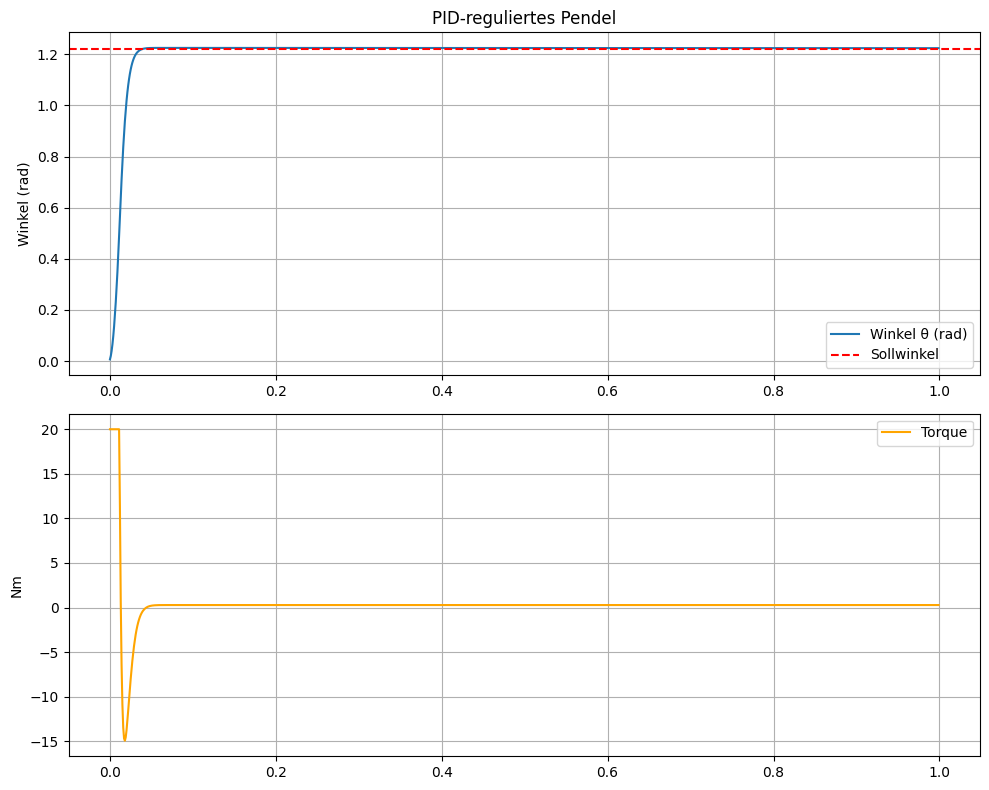

In [ ]:
Kp = 109.7263
Ki = 36.9617
Kd = 0.9539

# --------------------------------------------------------------
# Config
# --------------------------------------------------------------

T_total = 1
N_steps = int(T_total / DT)

# --------------------------------------------------------------
# Initialisierung
# --------------------------------------------------------------
theta = 0.0
theta_dot = 0.0
integral = 0.0
prev_error = 0.0

time_log = []
theta_log = []
theta_dot_log = []
control_log = []
error_log = []
integral_log = []
derivative_log = []

# --------------------------------------------------------------
# Simulation
# --------------------------------------------------------------
for step in range(N_steps):
    t = step * DT

    # Fehlerberechnung
    error = TARGET_ANGLE - theta
    integral += error * DT
    derivative = (error - prev_error) / DT  # Neuer D-Anteil
    prev_error = error

    # PID-Regler
    u = Kp * error + Ki * integral + Kd * derivative
    u = np.clip(u, MIN_TORQUE, MAX_TORQUE)

    # Dynamik des Pendels
    theta_dot_new = theta_dot + DT * (- (DAMPING / I) * theta_dot - (GRAVITY / LENGTH) * np.sin(theta) + (1.0 / I) * u)
    theta_new = theta + DT * theta_dot_new

    # Logs speichern
    time_log.append(t)
    theta_log.append(theta_new)
    theta_dot_log.append(theta_dot_new)
    control_log.append(u)
    error_log.append(error)
    integral_log.append(integral)
    derivative_log.append(derivative)


    # Für nächsten Schritt
    theta = theta_new
    theta_dot = theta_dot_new

# --------------------------------------------------------------
# Plots: Darstellung der Ergebnisse
# --------------------------------------------------------------
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(time_log, theta_log, label="Winkel θ (rad)")
plt.axhline(y=TARGET_ANGLE, color='r', linestyle='--', label="Sollwinkel")
plt.ylabel("Winkel (rad)")
plt.title("PID-reguliertes Pendel")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_log, control_log, label="Torque", color="orange")
plt.ylabel("Nm")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
